# OUR CNN 

This was our first try where we attempted at constructing from scratch our Convolutional Neural Networks for the classification task.
We managed to reach an avg classification accuracy of 62% on the test set of the Phase 1 of the competition.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/Colab Notebooks/ANN&DL First Challenge/dataset

/gdrive/My Drive/Colab Notebooks/ANN&DL First Challenge/dataset


In [3]:
# IMPORT ALL THE LIBRARIES 
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 4.1 MB/s 


In [4]:
# VISUALIZE THE TENSORFLOW VERSION 
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Check the GPU presence
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


2.7.0
SUCCESS: Found GPU: /device:GPU:0


In [5]:
# FIX RANDOM SEED FOR REPRODUCIBILITY 
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Explore dataset

In [ ]:
!unzip dataset.zip

In [6]:
# Define dataset directry 
dataset_dir = 'training'

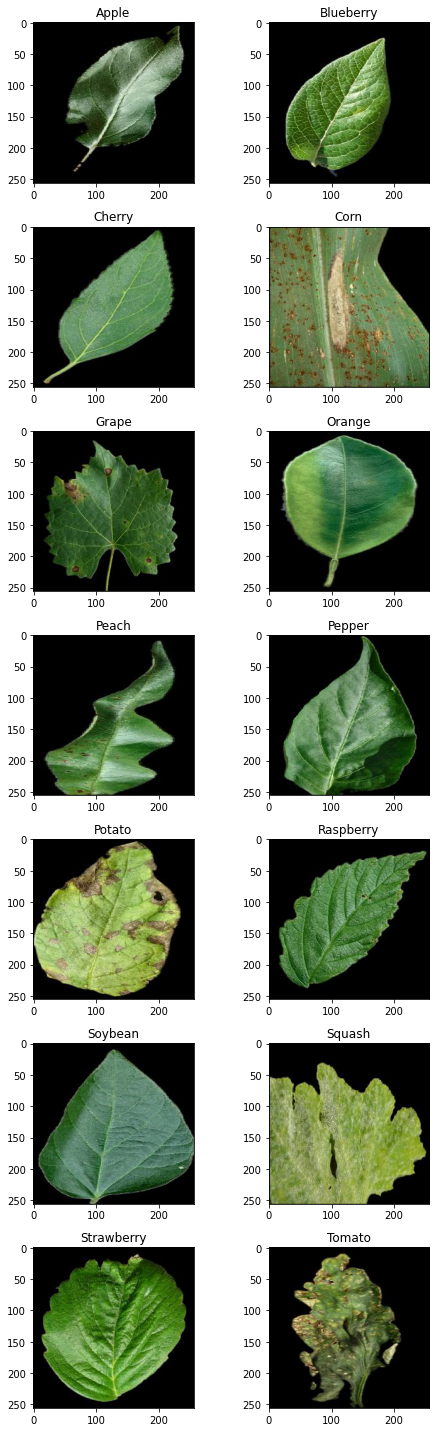

In [8]:
# VISUALIZE THE DATASET

# Classes 
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

# Plot example images from dataset
esegui_plot = True
if esegui_plot == True:
  num_row = len(labels)//2
  num_col = len(labels)//num_row
  fig, axes = plt.subplots(num_row, num_col, figsize=(1*num_row,10*num_col))
  for i in range(len(labels)):
    if i < len(labels):
      class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
      class_img = class_imgs[0]
      img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
      ax = axes[i//num_col, i%num_col]
      ax.imshow(np.array(img))
      ax.set_title('{}'.format(labels[i]))
  plt.tight_layout()
  plt.show()
    

## Play with Data Augmentation 

In [9]:
# Define an initial generator 
train_data_gen = ImageDataGenerator()

# Set batch size 
batch_size = 8

# Training set generation
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed,
                                               subset="training")

Found 17728 images belonging to 14 classes.


### One transformation at a time 

Rotation: {'theta': -10.036790492211, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': 38, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9247240713084175, 'zy': 1.2704285838459497, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

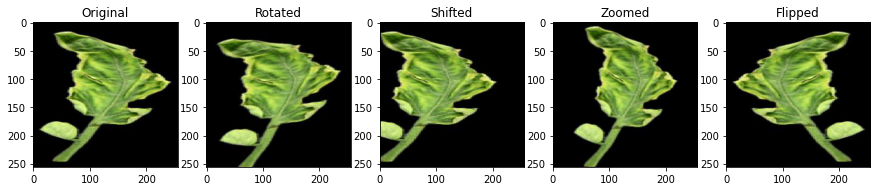

In [11]:
# Create some augmentation examples

# Get sample image (one image, the next one)
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen   = ImageDataGenerator(rotation_range=40)      # rotated sample generator 
shift_gen = ImageDataGenerator(width_shift_range=50)   # shifted sample generator
zoom_gen  = ImageDataGenerator(zoom_range=0.3)         # zoomed sample generator
flip_gen  = ImageDataGenerator(horizontal_flip=True)   # flipped sample generator

# Get random transformations of the image and print the specifics 
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Flip:', flip_t, '\n')

# APPLY THE TRANSFORMATIONS
gen     = ImageDataGenerator(fill_mode='constant', cval=0.)   # fill with zeros if the transf has generated null pixels 
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t) 
zoomed  = gen.apply_transform(image, zoom_t) 
flipped = gen.apply_transform(image, flip_t)  

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')

### Multiple transformation all together 

Transform: {'theta': -7.527592869158251, 'tx': -28, 'ty': 42, 'shear': 0, 'zx': 1.059195090518222, 'zy': 0.7936111842654618, 'flip_horizontal': 1, 'flip_vertical': 1, 'channel_shift_intensity': None, 'brightness': None}


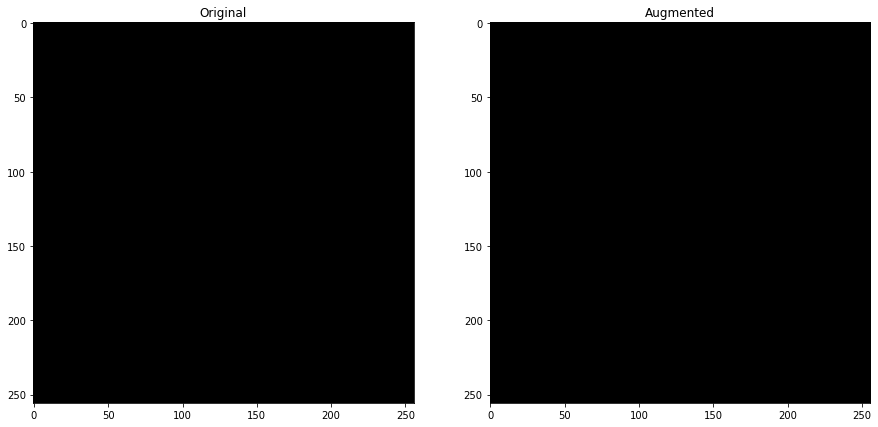

In [21]:
# MULTIPLE TRANSFORMATIONS AT THE SAME TIME

# Get sample image (one image, the next batch's one)
image = next(train_gen)[0][4]

# Combine multiple transformations 
gen = ImageDataGenerator(rotation_range=30,
                         height_shift_range=50,
                         width_shift_range=50,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True, 
                         fill_mode='constant',
                         rescale=None)

# Get random transformation
t = gen.get_random_transform(img_shape=(256, 256), seed=seed)

# Print the specifics of the random transformation 
print("Transform:", t)

# Apply the transformation
augmented = gen.apply_transform(image, t)

# PLOT ORIGINAL AND AUGMENTED IMAGES 
# Define a new figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(15,30))
# Plot the original image and set the title 
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
# Plot the augmented image and set the title 
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Augmented")
plt.show()

In [16]:
# Define auxiliary function for batch selection 
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

## Define Training and Validation set 

In [17]:
# Define a generator 
train_data_gen = ImageDataGenerator(validation_split=0.3,
                                     rotation_range=30,
                                     height_shift_range=50,
                                     width_shift_range=50,
                                     zoom_range=0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True, 
                                     fill_mode='constant',
                                     rescale=1/255)

# Set batch size 
batch_size = 8

# Training set generation
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed,
                                               subset="training")
# Validation set generation 
val_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed,
                                               subset="validation")

Found 12417 images belonging to 14 classes.
Found 5311 images belonging to 14 classes.


In [18]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: 13
Class name: Tomato
(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 14)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Apple


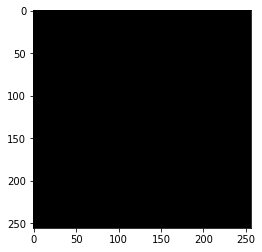

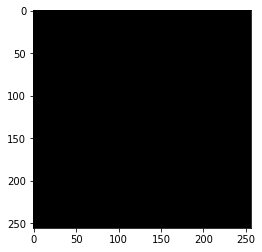

In [19]:
apply_get_next_batch = True
if apply_get_next_batch == True:
  _ = get_next_batch(train_gen)
if apply_get_next_batch == True:
  _ = get_next_batch(val_gen)

# Learning Phase 

## Training Hyperparameters 

In [20]:
input_shape = (256, 256, 3)
epochs = 50

## Build the model 

In [ ]:
# MODEL 02
# (Conv + ReLU + MaxPool) x 5 + FC x 2

def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # First convolution layer 
    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv10 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv1)
    # First pooling layer 
    pool1 = tfkl.MaxPooling2D(
        pool_size = (4, 4)
    )(conv10)
    conv1_1 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)

    # Second convolution layer 
    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv1_1)
    # Second pooling layer 
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)
    conv2_1 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)

    # Third convolution layer 
    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv2_1)
    # Third pooling layer 
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)
    conv3_1 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)

    # Fourth conv layer 
    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv3_1)
    # Fourth pooling layer 
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)
    conv4_1 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)

    
    flattening_layer = tfkl.Flatten(name='Flatten')(conv4_1)

    classifier_layer_1 = tfkl.Dense(units=128, name='Classifier_1', kernel_initializer=tfk.initializers.GlorotUniform(seed),
                                    activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-5)
                                    )(flattening_layer)
    dropout_layer_1    = tfkl.Dropout(0.4, seed=seed)(classifier_layer_1)
    
    classifier_layer_2 = tfkl.Dense(units=64, name='Classifier_2', kernel_initializer=tfk.initializers.GlorotUniform(seed),
                                    activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-5)
                                    )(dropout_layer_1)
    dropout_layer_2    = tfkl.Dropout(0.4, seed=seed)(classifier_layer_2)

    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(dropout_layer_2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.0003), metrics='accuracy')

    # Return the model
    return model

## Visualize the model 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        9248      
                                                             

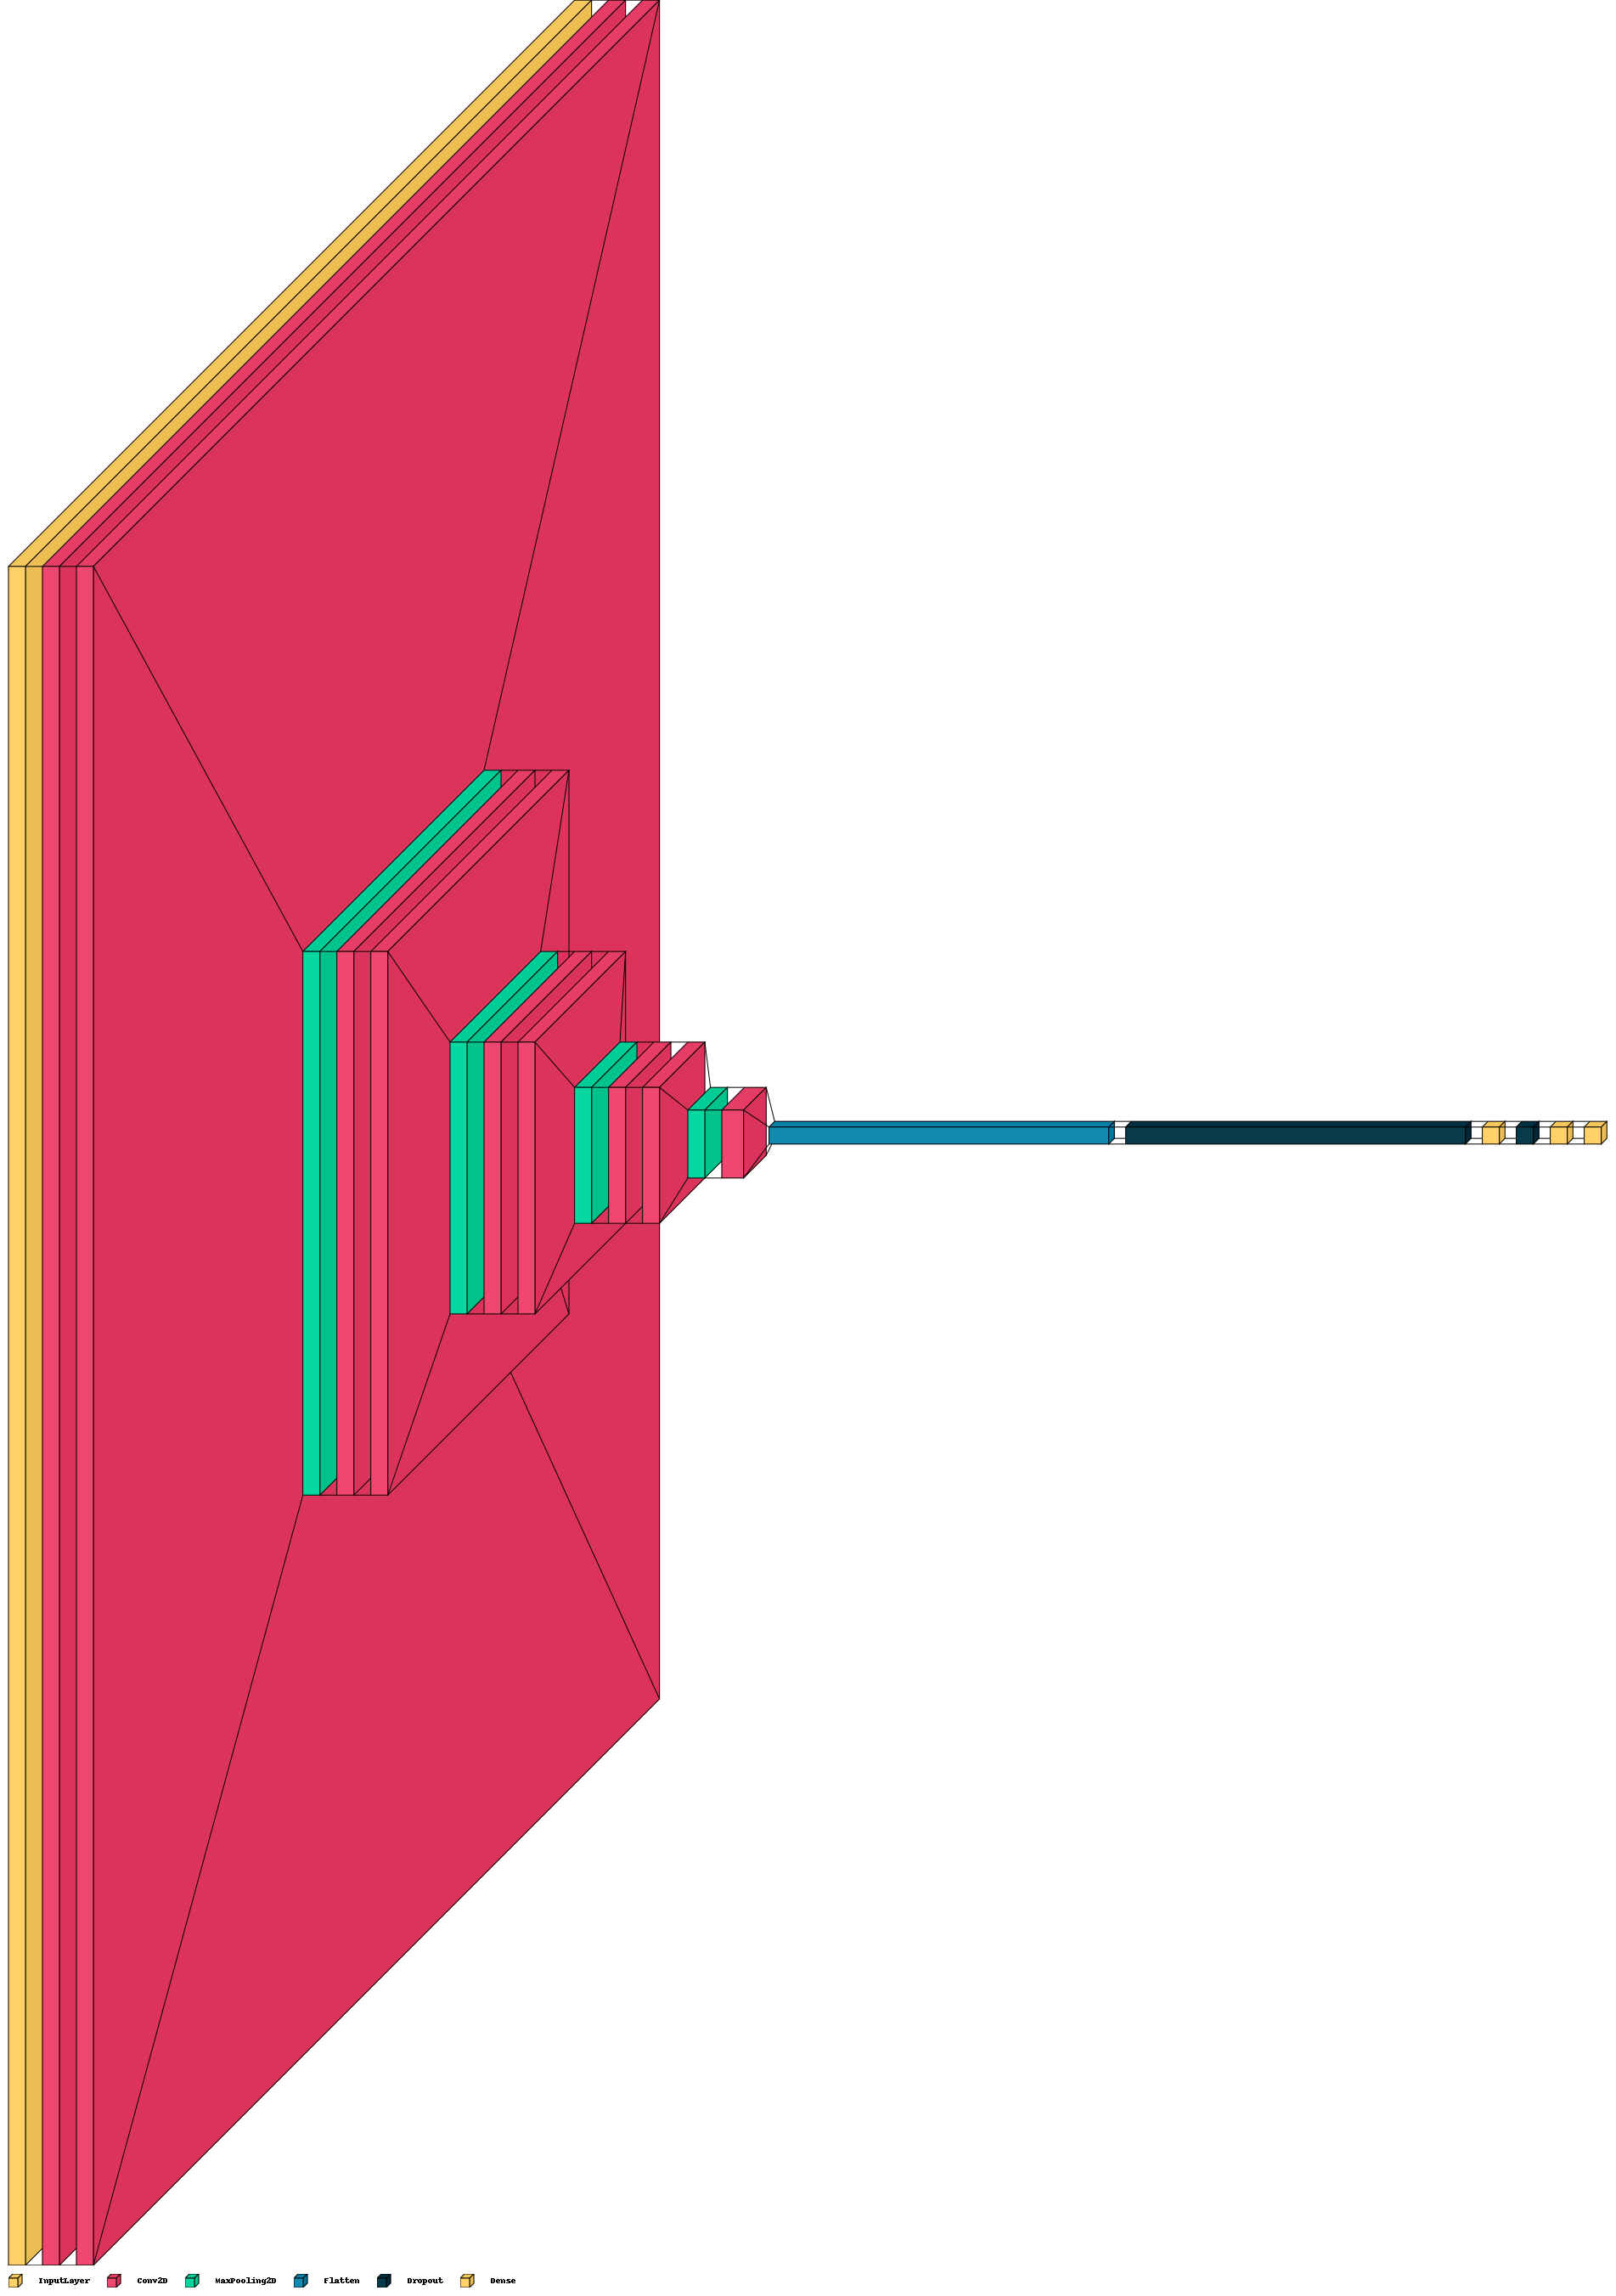

In [ ]:
# Construct the model 
model = build_model(input_shape)

# Visualize the number of parameters for each layer 
model.summary()

# Visualize the model in a schematic way 
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [ ]:
# Auxiliary function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
  
  # creates folders and callbacks, collected into a list, since the argument "callbacks" in the function .fit() requires a list

  exps_dir = os.path.join('models')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir) # creates and SETS the directory if not found

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
                                                                  # histogram_freq = 5 means that i want to save 1 in 5 epochs (e.g. 1, 6, 6+5, ...)
                                                                  # histogram_freq = 1 means that i want to save 1 in 5 epochs (e.g. 1, 2, 3, ...)
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

## Model Fitting 

In [ ]:
first_try_callbacks = create_folders_and_callbacks(model_name='CNN_first_try')

# Train the model
history = model.fit(
    x = train_gen, # the function .fit() understands that this is a generator, so it contains both the data and the labels (the targets)
    epochs = epochs,
    callbacks = first_try_callbacks,
    validation_data = val_gen
).history


Epoch 1/50
1553/1553 [==============================] - ETA: 0s - loss: 2.2181 - accuracy: 0.3345

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 638s 410ms/step - loss: 2.2181 - accuracy: 0.3345 - val_loss: 1.9843 - val_accuracy: 0.3807
Epoch 2/50
1553/1553 [==============================] - ETA: 0s - loss: 1.8039 - accuracy: 0.4301

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 576s 371ms/step - loss: 1.8039 - accuracy: 0.4301 - val_loss: 1.6756 - val_accuracy: 0.4831
Epoch 3/50
1553/1553 [==============================] - ETA: 0s - loss: 1.4476 - accuracy: 0.5530

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 577s 372ms/step - loss: 1.4476 - accuracy: 0.5530 - val_loss: 1.3065 - val_accuracy: 0.6070
Epoch 4/50
1553/1553 [==============================] - ETA: 0s - loss: 1.1733 - accuracy: 0.6372

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 577s 372ms/step - loss: 1.1733 - accuracy: 0.6372 - val_loss: 1.2120 - val_accuracy: 0.6221
Epoch 5/50
1553/1553 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.6741

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 580s 374ms/step - loss: 1.0382 - accuracy: 0.6741 - val_loss: 1.2738 - val_accuracy: 0.6430
Epoch 6/50
1553/1553 [==============================] - ETA: 0s - loss: 0.9106 - accuracy: 0.7172

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 577s 372ms/step - loss: 0.9106 - accuracy: 0.7172 - val_loss: 1.2500 - val_accuracy: 0.6503
Epoch 7/50
1553/1553 [==============================] - ETA: 0s - loss: 0.8204 - accuracy: 0.7494

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 578s 372ms/step - loss: 0.8204 - accuracy: 0.7494 - val_loss: 1.1487 - val_accuracy: 0.6712
Epoch 8/50
1553/1553 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.7671

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 579s 373ms/step - loss: 0.7563 - accuracy: 0.7671 - val_loss: 0.9537 - val_accuracy: 0.7140
Epoch 9/50
1553/1553 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.7906

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 577s 372ms/step - loss: 0.6683 - accuracy: 0.7906 - val_loss: 0.8535 - val_accuracy: 0.7434
Epoch 10/50
1553/1553 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.8028

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 579s 373ms/step - loss: 0.6344 - accuracy: 0.8028 - val_loss: 1.0674 - val_accuracy: 0.7061
Epoch 11/50
1553/1553 [==============================] - ETA: 0s - loss: 0.5848 - accuracy: 0.8213

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 589s 379ms/step - loss: 0.5848 - accuracy: 0.8213 - val_loss: 0.8499 - val_accuracy: 0.7496
Epoch 12/50
1553/1553 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.8338

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 575s 370ms/step - loss: 0.5405 - accuracy: 0.8338 - val_loss: 1.1599 - val_accuracy: 0.7183
Epoch 13/50
1553/1553 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.8469

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 575s 370ms/step - loss: 0.5119 - accuracy: 0.8469 - val_loss: 0.8845 - val_accuracy: 0.7505
Epoch 14/50
1553/1553 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.8566

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 581s 374ms/step - loss: 0.4781 - accuracy: 0.8566 - val_loss: 1.0243 - val_accuracy: 0.7317
Epoch 15/50
1553/1553 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8743

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 579s 373ms/step - loss: 0.4305 - accuracy: 0.8743 - val_loss: 1.2773 - val_accuracy: 0.7213
Epoch 16/50
1553/1553 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.8772

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 580s 374ms/step - loss: 0.4207 - accuracy: 0.8772 - val_loss: 0.7509 - val_accuracy: 0.8049
Epoch 17/50
1553/1553 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.8857

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 574s 370ms/step - loss: 0.3970 - accuracy: 0.8857 - val_loss: 0.8046 - val_accuracy: 0.7861
Epoch 18/50
1553/1553 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8870

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 574s 369ms/step - loss: 0.3927 - accuracy: 0.8870 - val_loss: 0.9848 - val_accuracy: 0.7901
Epoch 19/50
1553/1553 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.9046

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 574s 369ms/step - loss: 0.3342 - accuracy: 0.9046 - val_loss: 1.0668 - val_accuracy: 0.7720
Epoch 20/50
1553/1553 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.9035

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 578s 372ms/step - loss: 0.3430 - accuracy: 0.9035 - val_loss: 1.2640 - val_accuracy: 0.7675
Epoch 21/50
1553/1553 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.9082

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 578s 372ms/step - loss: 0.3284 - accuracy: 0.9082 - val_loss: 0.8974 - val_accuracy: 0.7972
Epoch 22/50
1553/1553 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.9118

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 575s 370ms/step - loss: 0.3162 - accuracy: 0.9118 - val_loss: 0.8614 - val_accuracy: 0.8015
Epoch 23/50
1553/1553 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.9154

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 576s 371ms/step - loss: 0.3096 - accuracy: 0.9154 - val_loss: 1.0081 - val_accuracy: 0.7870
Epoch 24/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.9195

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 574s 369ms/step - loss: 0.2854 - accuracy: 0.9195 - val_loss: 1.0572 - val_accuracy: 0.7778
Epoch 25/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.9214

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 577s 372ms/step - loss: 0.2807 - accuracy: 0.9214 - val_loss: 1.4373 - val_accuracy: 0.7688
Epoch 26/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9242

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 576s 371ms/step - loss: 0.2700 - accuracy: 0.9242 - val_loss: 0.6895 - val_accuracy: 0.8243
Epoch 27/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.9273

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 578s 372ms/step - loss: 0.2639 - accuracy: 0.9273 - val_loss: 0.7422 - val_accuracy: 0.8309
Epoch 28/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9307

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 579s 373ms/step - loss: 0.2615 - accuracy: 0.9307 - val_loss: 1.3564 - val_accuracy: 0.7791
Epoch 29/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.9328

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 578s 372ms/step - loss: 0.2535 - accuracy: 0.9328 - val_loss: 0.5869 - val_accuracy: 0.8486
Epoch 30/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.9352

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 581s 374ms/step - loss: 0.2440 - accuracy: 0.9352 - val_loss: 0.7289 - val_accuracy: 0.8187
Epoch 31/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9353

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 578s 372ms/step - loss: 0.2377 - accuracy: 0.9353 - val_loss: 0.9150 - val_accuracy: 0.8172
Epoch 32/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9370

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 577s 372ms/step - loss: 0.2340 - accuracy: 0.9370 - val_loss: 0.8290 - val_accuracy: 0.8255
Epoch 33/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9383

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 578s 372ms/step - loss: 0.2348 - accuracy: 0.9383 - val_loss: 0.7952 - val_accuracy: 0.8307
Epoch 34/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9421

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 580s 373ms/step - loss: 0.2160 - accuracy: 0.9421 - val_loss: 0.8166 - val_accuracy: 0.8283
Epoch 35/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9435

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 580s 374ms/step - loss: 0.2193 - accuracy: 0.9435 - val_loss: 1.1468 - val_accuracy: 0.8047
Epoch 36/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9425

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 582s 375ms/step - loss: 0.2204 - accuracy: 0.9425 - val_loss: 0.9909 - val_accuracy: 0.7893
Epoch 37/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9428

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 580s 374ms/step - loss: 0.2157 - accuracy: 0.9428 - val_loss: 0.6931 - val_accuracy: 0.8268
Epoch 38/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9431

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 580s 373ms/step - loss: 0.2193 - accuracy: 0.9431 - val_loss: 0.5375 - val_accuracy: 0.8620
Epoch 39/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9461

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 579s 373ms/step - loss: 0.2103 - accuracy: 0.9461 - val_loss: 0.6403 - val_accuracy: 0.8443
Epoch 40/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9508

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 579s 373ms/step - loss: 0.2014 - accuracy: 0.9508 - val_loss: 0.9112 - val_accuracy: 0.8204
Epoch 41/50
1553/1553 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9520

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 577s 372ms/step - loss: 0.1928 - accuracy: 0.9520 - val_loss: 0.9158 - val_accuracy: 0.8277
Epoch 42/50
1553/1553 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9427

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 578s 372ms/step - loss: 0.2139 - accuracy: 0.9427 - val_loss: 0.8448 - val_accuracy: 0.8191
Epoch 43/50
1553/1553 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9555

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 582s 375ms/step - loss: 0.1829 - accuracy: 0.9555 - val_loss: 1.1772 - val_accuracy: 0.7795
Epoch 44/50
1553/1553 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9522

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 579s 373ms/step - loss: 0.1927 - accuracy: 0.9522 - val_loss: 0.7868 - val_accuracy: 0.8330
Epoch 45/50
1553/1553 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9544

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 581s 374ms/step - loss: 0.1840 - accuracy: 0.9544 - val_loss: 0.8394 - val_accuracy: 0.8247
Epoch 46/50
1553/1553 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9575

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 581s 374ms/step - loss: 0.1698 - accuracy: 0.9575 - val_loss: 0.9343 - val_accuracy: 0.8253
Epoch 47/50
1553/1553 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9546

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


1553/1553 [==============================] - 584s 376ms/step - loss: 0.1816 - accuracy: 0.9546 - val_loss: 0.7180 - val_accuracy: 0.8375
Epoch 48/50
1553/1553 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9559

INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets


INFO:tensorflow:Assets written to: models\CNN_first_try_Nov22_19-42-57\ckpts\cp.ckpt\assets



1553/1553 [==============================] - 585s 377ms/step - loss: 0.1760 - accuracy: 0.9559 - val_loss: 1.0494 - val_accuracy: 0.8123


## Plot the accuracy of the Training and Validation sets

In [ ]:
# Save the model in a specified folder 
model.save("CNN_Delvi")

INFO:tensorflow:Assets written to: CNN_Delvi\assets


INFO:tensorflow:Assets written to: CNN_Delvi\assets


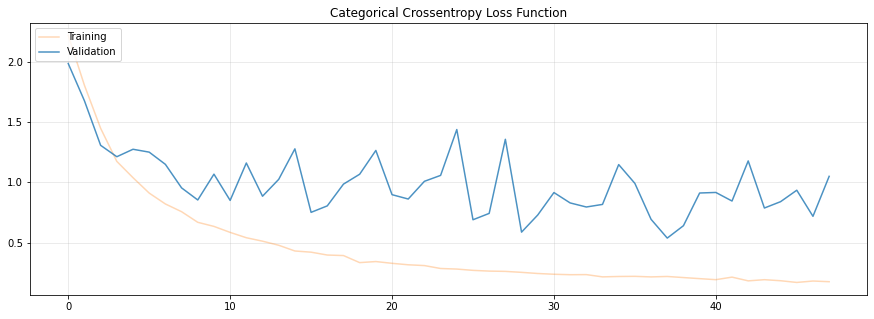

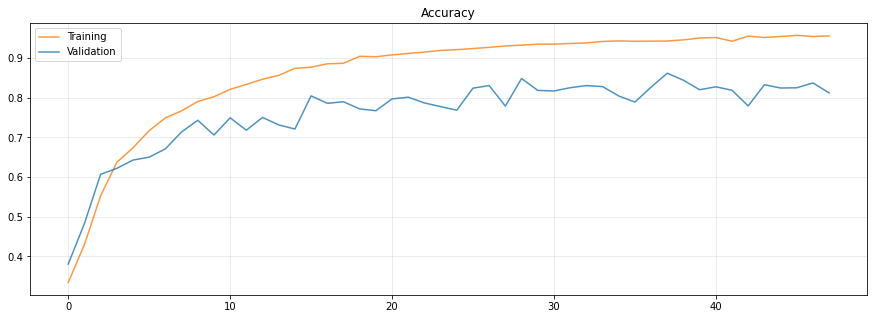

In [ ]:
# TRAINING VISUALIZATION 

# Plot the training error & validation error 
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy Loss Function')
plt.grid(alpha=.3)


# Plot the accuracy level in training and validation
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8)
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
def monitor(histories, names, colors, early_stopping=1): 
  # function that plots the MSE of the training and validation sets, using an early stopping
    assert len(histories) == len(names) # "assert" helps detect problems early in your program, where the cause is clear, rather than later when some other operation fails
    assert len(histories) == len(colors)
    plt.figure(figsize=(15,6))
    for idx in range(len(histories)): # histories will store the MSE both of the training and the validation set
        plt.plot(histories[idx]['accuracy'][:-early_stopping], label=names[idx]+' Training', alpha=.4, color=colors[idx], linestyle='--')
        plt.plot(histories[idx]['val_accuracy'][:-early_stopping], label=names[idx]+' Validation', alpha=.8, color=colors[idx])   
    #plt.ylim(0.0075, 0.02)
    plt.title('Accuracy')
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid(alpha=.3)
    plt.show()
print(history["loss"])


[2.2180726528167725, 1.803862452507019, 1.447614073753357, 1.1732873916625977, 1.0382024049758911, 0.910554826259613, 0.8203524351119995, 0.7563089728355408, 0.6682705283164978, 0.6343603730201721, 0.584754467010498, 0.5404731035232544, 0.5118638277053833, 0.4781065881252289, 0.43051856756210327, 0.4207402467727661, 0.3970220983028412, 0.39274120330810547, 0.3341878354549408, 0.3429768681526184, 0.32837554812431335, 0.31623148918151855, 0.30961471796035767, 0.2854250967502594, 0.2807272970676422, 0.2699868083000183, 0.26385781168937683, 0.2614535391330719, 0.25351622700691223, 0.2439916431903839, 0.23769815266132355, 0.2339726835489273, 0.23477479815483093, 0.21599441766738892, 0.21926195919513702, 0.2203812450170517, 0.2157421112060547, 0.21930401027202606, 0.21028970181941986, 0.20136448740959167, 0.1927686184644699, 0.21385769546031952, 0.18294209241867065, 0.19266635179519653, 0.1840278059244156, 0.16979579627513885, 0.1815595179796219, 0.17599955201148987]


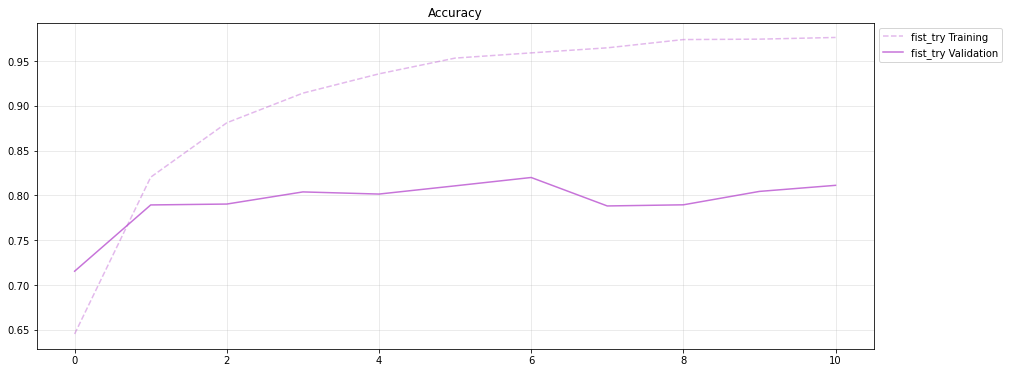

[1.1555771827697754, 0.574141263961792, 0.380719929933548, 0.26159629225730896, 0.20149612426757812, 0.14576449990272522, 0.12248287349939346, 0.10705774277448654, 0.08576428890228271, 0.08400621265172958, 0.07811266928911209, 0.07136967033147812]


In [ ]:
histories=[]
colors=[]
names=[]
histories.append(history)
names.append('fist_try')
colors.append('#B951D0')
patience  = 50
monitor(histories, names, colors, 1)
print(history["loss"])


# Performace Measurement  

## Confusion Matrix 

In [ ]:
# PERFORMANCE MEASURES OF THE CNN

model = tfk.models.load_model('CNN')
predictions = model.predict(val_gen)
predictions.shape  

# Compute the confusion matrix (confusion_matrix is a command that we have imported)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy  = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall    = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1        = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Plot the classification metrics 
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()